# Exercise 8: Sound transformations

In this exercise you will use the HPS model to creatively transform sounds. There are two parts in this exercise. In the first one you should perform a natural sounding transformation on the speech sound that you used in the previous exercise (E7). In the second part you should select a sound of your choice and do a "creative" transformation. You will have to write a short description of the sound and of the transformation you did, giving the link to the original sound and uploading several transformed sounds.

For this exercise, you can use the `transformations_GUI.py` (in `software/transformations_interface/`) to try things, once decided you can fill up the code in this file. You can also do everything from here and add any new code you wish.

In order to perform a good/interesting transformation you should make sure that you have performed an analysis that is adequate for the type of transformation you want to do. Not every HPS analysis representation will work for every type of sound transformation. There will be things in the analysis that when modified will result in undesired artifacts. In general, for any transformation, it is best to have the harmonic values as smooth and continuous as possible and an stochastic representation as smooth and with as few values as possible. It might be much better to start with an analysis representation that does not result in the best reconstruction in exchange of having smoother and more compact data.

To help you with the exercise, we give a brief description of the transformation parameters used by the HPS transformation function:

1. `freqScaling`: frequency scaling factors to be applied to the harmonics of the sound, in time-value pairs (where value of 1 is no scaling). The time values can be normalized, from 0 to 1, or can correspond to the times in seconds of the input sound. The scaling factor is a multiplicative factor, thus a value of 1 is no change. Example: to transpose an octave the sound you can specify `[0, 2, 1, 2]`.
2. `freqStretching`: frequency stretching factors to be applied to the harmonics of the sound, in time-value pairs (value of 1 is no stretching). The time values can be normalized, from 0 to 1, or can correspond to the times in seconds of the input sound. The stretching factor is a multiplicative factor whose effect depend on the harmonic number, higher harmonics being more affected that lower ones, thus resulting in an inharmonic effect. A value of 1 results in no transformation. Example: an array like `[0, 1.2, 1, 1.2]` will result in a perceptually large inharmonic effect.
3. `timbrePreservation`: 1 preserves the original timbre, 0 does not. It can only have a value of 0 or of 1. By setting the value to 1 the spectral shape of the original sound is preserved even when the frequencies of the sound are modified. In the case of speech it would correspond to the idea of preserving the identity of the speaker after the transformation.
4. `timeScaling`: time scaling factors to be applied to the whole sound, in time-value pairs (value of 1 is no scaling). The time values can be normalized, from 0 to 1, or can correspond to the times in seconds of the input sound. The time scaling factor is a multiplicative factor, thus 1 is no change. Example: to stretch the original sound to twice the original duration, we can specify `[0, 0, 1, 2]`.

All the transformation values can have as many points as desired, but they have to be in the form of an array with time-value pairs, so of even size. For example a good array for a frequency stretching of a sound that has a duration of 3.146 seconds could be: `[0, 1.2, 2.01, 1.2, 2.679, 0.7, 3.146, 0.7]`.

## Part 1. Perform natural sounding transformations of a speech sound

Use the HPS model with the sound `speech-female.wav`, available in the sounds directory, to first analyze and then obtain a natural sounding transformation of the sound. The synthesized sound should sound as different as possible to the original sound while sounding natural. By natural we mean that it should sound like speech, that it could have been possible to be produced by a human, and by listening we should consider it as a speech sound, even though we might not be able to understand it. You should first make sure that you start from a good analysis, then you can do time and/or frequency scaling transformations. The transformation should be done with a single pass, no mixing of sounds coming from different transformations. Since you used the same sound in A7, use that experience to get a good analysis, but consider that the analysis, given that we now want to use it for applying a very strong transformation, might be done differently than what you did in A7.

Write a short paragraph for every transformation, explaining what you wanted to obtain and explaining the transformations you did, giving both the analysis and transformation parameter values (sufficiently detailed for the evaluator to be able to reproduce the analysis and transformation).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window
import sys, os
sys.path.append('../software/models/')
sys.path.append('../software/transformations/')
import utilFunctions as UF
import stft as STFT
import hpsModel as HPS
import hpsTransformations as HPST
import harmonicTransformations as HT
import IPython.display as ipd

In [2]:
# 1.1 perform an analysis/synthesis using the HPS model

input_file = '../sounds/speech-female.wav'

### set the parameters
window ='hamming'
M = 1601
N = 2048
t = -95
minSineDur = 0.0515
nH = 75 
minf0 = 120
maxf0 = 290
f0et = 1
harmDevSlope = 0.0095
stocf = 0.475

# no need to modify anything after this
Ns = 512
H = 128

(fs, x) = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
hfreq, hmag, hphase, stocEnv = HPS.hpsModelAnal(x, fs, w, N, H, t, nH, minf0, maxf0, f0et, harmDevSlope, minSineDur, Ns, stocf)
y, yh, yst = HPS.hpsModelSynth(hfreq, hmag, hphase, stocEnv, Ns, H, fs)

print("input sound: ")
ipd.display(ipd.Audio(data=x, rate=fs))

print("\noutput sound")
ipd.display(ipd.Audio(data=y, rate=fs))

print("\nharmonic component".format(stocf))
ipd.display(ipd.Audio(data=yh, rate=fs))

print("\nstochastic component - stocf = {}".format(stocf))
ipd.display(ipd.Audio(data=yst, rate=fs))

input sound: 



output sound



harmonic component



stochastic component - stocf = 0.475


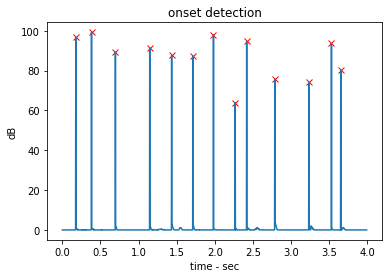

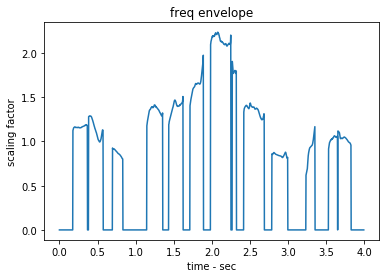

music intervals = [2, 2, 1, 2, 2, 2, 1, -3, -4, -3, -2, -1, 1]

time envelope =  [0.         0.         0.17705215 0.25       0.38312925 0.5
 0.69659864 0.75       1.14648526 1.         1.4338322  1.25
 1.71247166 1.5        1.98240363 1.75       2.26684807 2.
 2.41777778 2.25       2.78639456 2.5        3.23337868 2.75
 3.52943311 3.         3.65133787 3.25      ]

frequency envelope =  [0.00000000e+00 0.00000000e+00 2.90249433e-03 ... 0.00000000e+00
 3.99092971e+00 0.00000000e+00]


In [3]:
from scipy.signal import find_peaks
eps = np.finfo(float).eps

# compute onsets
def compute_onset(hfreq, hmag):
    energy_envelope = []
    for i in range( len(hfreq) ):
        idx = np.where( ( hfreq[i,:] > 100 ) & ( hfreq[i,:] < 4000 ) )[0] # evaluation range 100 Hz - 4 Khz
        E = ( 10**(hmag[i,idx]/20) @ 10**(hmag[i,idx]/20) ) / (2*len(hfreq)) # energy of the band
        E_dB = 10 * np.log10 ( E + eps ) # energy of the band in dB
        energy_envelope.append( E_dB ) # energy envelope
    
    E_diff = np.diff( energy_envelope ) # difference
    E_diff[ np.where( E_diff < 0 ) ] = 0 # half wave rectification
    E_diff = np.insert(E_diff,0,0) # insert 0 value at the beginning of the frame
    
    idx_peaks = find_peaks( E_diff/np.max(E_diff), height=0.5)[0] # index peaks
    return energy_envelope, E_diff, idx_peaks

energy_envelope, onsets, idx_peaks= compute_onset(hfreq, hmag)

# melody
melody = [2, 2, 1, 2, 2, 2, 1, -3, -4, -3, -2, -1, 1]
# random melody
intervals = [-3, -2, 2, 3]
prob_intervals = [0.25, 0.25, 0.25, 0.25]
#melody = np.random.choice(intervals, len(idx_peaks), prob_intervals) # uncomment me for playing!!!

# factors for the frequency envelope
tuning_note = hfreq[idx_peaks,0][0] # tuning note for the intervals relations
freq_factors = np.zeros( len(hfreq) )
pointer = 0
note = 0
for i in  range(len( hfreq )):
    if hfreq[i,0] == 0:
        continue
    if 1 in (i / idx_peaks):
        pointer = np.where(i / idx_peaks == 1)[0]
        note = note + melody[int(pointer)]
    freq_factors[i] = 2 ** (note/12) * tuning_note / hfreq[i,0] 
    
# frequency envelope
freq_envelope = np.zeros(len(hfreq)*2)
freq_envelope[0::2] = np.arange(len(hfreq))*H/fs
freq_envelope[1::2] = freq_factors

# time envelope
note_duration = 0.25 # in seconds
time_envelope = np.zeros(len(idx_peaks)*2)
time_envelope[0::2] = idx_peaks*H/fs
time_envelope[1::2] = (np.arange(len(idx_peaks)) + 1)*note_duration
time_envelope = np.insert(time_envelope,[0,0],[0,0])

# plotting
frmTime = H*np.arange(len(hfreq))/float(fs)
plt.plot( H*idx_peaks/float(fs), onsets[idx_peaks], linestyle='None', marker='x', color='r' ) # plotting peaks
plt.plot(frmTime, onsets)
plt.title("onset detection")
plt.ylabel("dB")
plt.xlabel("time - sec")
plt.show()

plt.plot(np.arange(len(hfreq))*H/float(fs), freq_envelope[1::2])
plt.title("freq envelope")
plt.ylabel("scaling factor")
plt.xlabel("time - sec")
plt.show()

print("music intervals =", melody)
print("\ntime envelope = ", time_envelope)
print("\nfrequency envelope = ", freq_envelope)

In [4]:
# 1.2 Perform a transformation from the previous analysis

### define the transformations
freqScaling = np.array(freq_envelope)
freqStretching = np.array([0,1,1,1])
timbrePreservation = 1
timeScaling = np.array(time_envelope)


# no need to modify the following code 
Ns = 512
H = 128

# frequency scaling of the harmonics 
hfreqt, hmagt = HT.harmonicFreqScaling(hfreq, hmag, freqScaling, freqStretching, timbrePreservation, fs)

# time scaling the sound
yhfreq, yhmag, ystocEnv = HPST.hpsTimeScale(hfreqt, hmagt, stocEnv, timeScaling)

# synthesis from the trasformed hps representation 
y, yh, yst = HPS.hpsModelSynth(yhfreq, yhmag, np.array([]), ystocEnv, Ns, H, fs)

print("input sound: ")
ipd.display(ipd.Audio(data=x, rate=fs))

print("transformed sound: ")
ipd.display(ipd.Audio(data=y, rate=fs))

input sound: 


transformed sound: 


### Explain Part 1
#### Frequency transformation
The idea is to make the voice sing.

1) There is a simple function for onset detection of the harmonic signal: `compute_onset`

2) The melody is given as an array of successive musical intervals (e.g. a mayor scale is `[2,2,1,2,2,2,1]`).

3) Each note of the melody is bounded in time by the onsets

4) The frequency envelope is computed so that each note is stable over the segment bounded by the onsets.

The commented line `melody = np.random.choice(intervals, len(idx_peaks), prob_intervals) # uncomment me for playing!!!` can be uncommented for generating random melodies 
The frequency envelope is stored in the `freq_envelope` variable

#### Time transformation
The time envelope is made so that each not bounded by the onsets has the same duration. 

The `note_duration` variable can be modified for playing with different note durations.

The time envelop is stored in the `time_envelope` variable.

## Part 2. Perform creative transformations with a sound of your choice

Pick any natural and harmonic sound from Freesound and use the HPS model to do the most creative and interesting transformation you can come up with. Sounding as different as possible from the original sound.

It is essential that you start with a natural harmonic sound. Examples include (but not limited to) any acoustic harmonic instrument, speech, harmonic sound from nature, etc. As long as they have a harmonic structure, you can use it. You can even reuse the sound you used in A7-Part2 or upload your own sound to freesound and then use it.

The sound from Freesound to use could be in any format, but to use the sms-tools software you will have to first convert it to be a monophonic file (one channel), sampling rate of 44100, and 16bits samples.

You can do any interesting transformation with a single pass. It is not allowed to mix sounds obtained from different transformations. The transformed sound need not sound natural. So, time to show some creativity!

Write a short paragraph for every transformation, explaining what you wanted to obtain and explaining the transformations you did, giving both the analysis and transformation parameter values (sufficiently detailed for the evaluator to be able to reproduce the analysis and transformation).

In [5]:
# 1.1 perform an analysis/synthesis using the HPS model

### set the parameters
input_file = '../sounds/speedyrce__cello-mono.wav'
window ='hamming'
M = 2801
N = 4096
t = -100
minSineDur = 0.1
nH = 75
minf0 = 65
maxf0 = 85
f0et = 2
harmDevSlope = 0.00065
stocf = 0.65

# no need to modify anything after this
Ns = 512
H = 128

(fs, x) = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
hfreq, hmag, hphase, stocEnv = HPS.hpsModelAnal(x, fs, w, N, H, t, nH, minf0, maxf0, f0et, harmDevSlope, minSineDur, Ns, stocf)
y, yh, yst = HPS.hpsModelSynth(hfreq, hmag, hphase, stocEnv, Ns, H, fs)

print("input sound: ")
ipd.display(ipd.Audio(data=x, rate=fs))

print("\noutput sound")
ipd.display(ipd.Audio(data=y, rate=fs))

print("\nharmonic component".format(stocf))
ipd.display(ipd.Audio(data=yh, rate=fs))

print("\nstochastic component - stocf = {}".format(stocf))
ipd.display(ipd.Audio(data=yst, rate=fs))

//anaconda3/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


input sound: 



output sound



harmonic component



stochastic component - stocf = 0.65


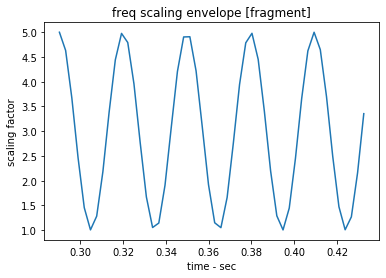

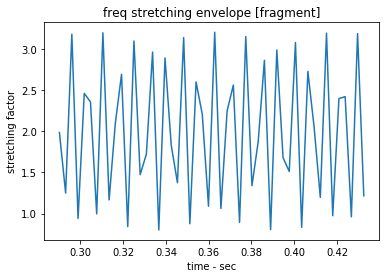

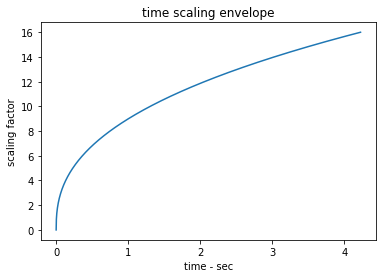

In [6]:
# frequency scaling envelope
freq_scaling_factors = np.zeros( len(hfreq) )
A_scaling = 2 # change me for playing!!!
f_scaling = 1e3 # change me for playing!!!
octave = 3
for i in  range(len( hfreq )):
    if hfreq[i,0] == 0:
        continue
    freq_scaling_factors[i] = octave + A_scaling * np.sin(2*np.pi*f_scaling * i*H/fs)

freq_scaling_envelope = np.zeros(len(hfreq)*2)
freq_scaling_envelope[0::2] = np.arange(len(hfreq))*H/fs
freq_scaling_envelope[1::2] = freq_scaling_factors


# frequency stretching envelope
freq_stretching_factors = np.zeros( len(hfreq) )
A_stretching = 1.2 # change me for playing!!!
f_stretching = 4e3 # change me for playing!!!
octave = 2
for i in  range(len( hfreq )):
    if hfreq[i,0] == 0:
        continue
    freq_stretching_factors[i] = octave + A_stretching * np.sin(2*np.pi*f_stretching * i*H/fs)

freq_stretching_envelope = np.zeros(len(hfreq)*2)
freq_stretching_envelope[0::2] = np.arange(len(hfreq))*H/fs
freq_stretching_envelope[1::2] = freq_stretching_factors


# time scaling envelope
duration = 16 # change me for playing!!!
power = 2/5 # change me for playing!!!
time_envelope = np.zeros(len(hfreq)*2)
time_envelope[0::2] = np.arange(len(hfreq))*H/fs
time_envelope[1::2] = duration * (np.linspace(0,1,len(hfreq)) ** (power) )


# plotting
# frequency scaling envelope - fragment
frmTime = H*np.arange(len(hfreq))/float(fs)
plt.plot(frmTime[100:150], freq_scaling_factors[100:150])
plt.title("freq scaling envelope [fragment]")
plt.ylabel("scaling factor")
plt.xlabel("time - sec")
plt.show()

# frequency stretching envelope - fragment
frmTime = H*np.arange(len(hfreq))/float(fs)
plt.plot(frmTime[100:150], freq_stretching_factors[100:150])
plt.title("freq stretching envelope [fragment]")
plt.ylabel("stretching factor")
plt.xlabel("time - sec")
plt.show()

# time scaling envelope - fragment
frmTime = H*np.arange(len(hfreq))/float(fs)
plt.plot(frmTime, time_envelope[1::2])
plt.title("time scaling envelope")
plt.ylabel("scaling factor")
plt.xlabel("time - sec")
plt.show()

In [7]:
# 1.2 Perform a transformation from the previous analysis

### define the transformations
freqScaling = np.array(freq_scaling_envelope)
freqStretching = np.array(freq_stretching_envelope)
timbrePreservation = 0
timeScaling = np.array(time_envelope)

# no need to modify anything after this
Ns = 512
H = 128

# frequency scaling of the harmonics 
hfreqt, hmagt = HT.harmonicFreqScaling(hfreq, hmag, freqScaling, freqStretching, timbrePreservation, fs)

# time scaling the sound
yhfreq, yhmag, ystocEnv = HPST.hpsTimeScale(hfreqt, hmagt, stocEnv, timeScaling)

# synthesis from the trasformed hps representation 
y, yh, yst = HPS.hpsModelSynth(yhfreq, yhmag, np.array([]), ystocEnv, Ns, H, fs)

print("input sound: ")
ipd.display(ipd.Audio(data=x, rate=fs))

print("transformed sound: ")
ipd.display(ipd.Audio(data=y, rate=fs))

input sound: 


transformed sound: 


### Explain Part 2

Link of the sound in freesound: https://freesound.org/people/speedyrce/sounds/329777/

### Frequency scaling
The frequencies were scaled in an oscillatory way. 

 The core line for this is: 
`freq_scaling_factors[i] = octave + A_scaling * np.sin(2*np.pi*f_scaling * i*H/fs)`. 

With the help of this line, each frame has a frequency scaling factor obtained with a sine wave. The offset of this sine wave defines the octave change in the frame. The parameters `octave`, `A_scaling` and `f_scaling` can be changed to enjoy exploring transfomations.

The frequency scaling envelope is stored in the `freq_scaling_envelope` variable

### Frequency streching
Similar to what has done in frequency scaling, the frequencies were modified in an oscillatory way, although this time the frequencies were not scaled but stretched.

The core line for this is: 
`freq_stretching_factors[i] = octave + A_stretching * np.sin(2*np.pi*f_stretching * i*H/fs)`

The parameters `octave`, `A_stretching` and `f_stretching` can be changed to enjoy exploring transfomations.

The frequency stretching envelope is stored in the `freq_stretching_envelope` variable


### Time scaling
A power function shapes the time envelope.

The core line for this is:
`duration * (np.linspace(0,1,len(hfreq)) ** (power) )`

The parameters `duration` and `power` can be changed to enjoy exploring transfomations.

The time scaling envelope is stored in the `time_scaling_envelope` variable